## COMP5328 - Advanced Machine Learning
## Assignment 1: Non-negative Matrix Factorization
----------------------------------------------------------------------------------------

**(Semester 2, 2025)**

In this ipython notebook, we provide some example code for assignment1.
+ Load Data.
    - ORL dataset.
    - Extended YaleB dataset.
    - AR dataset (**optional**).
+ Perform Evaluation.
   - Relative Reconstruction Errors.
   - Accuracy, NMI (**optional**).

Lecturer: Tongliang Liu.

**Note: All datasets can be used only for this assignment and you are not allowed to distribute these datasets. If you want to use AR dataset, you need to apply it by yourself (we do not provide AR dataset due to the problem of license, please find more details in http://www2.ece.ohio-state.edu/~aleix/ARdatabase.html).**

## 1. Load Dataset

### 1.0 Data Folder

In [16]:
from google.colab import drive
drive.mount('/content/drive')

# Path to your dataset zip stored in Drive
zip_path = "/content/drive/MyDrive/comp4328/a1/data.zip"

# Unzip into Colab local filesystem
!unzip -q "$zip_path" -d /content/data

# Inspect structure
!ls -R /content/data | head -20


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
replace /content/data/data/CroppedYaleB/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: /content/data:
data
__MACOSX

/content/data/data:
CroppedYaleB
ORL

/content/data/data/CroppedYaleB:
yaleB01
yaleB02
yaleB03
yaleB04
yaleB05
yaleB06
yaleB07
yaleB08
yaleB09
yaleB10
yaleB11


In [17]:
# The structure of data folder.
!ls -l data

total 8
drwx------ 4 root root 4096 Aug 25  2018 data
drwxrwxr-x 3 root root 4096 Aug 25  2018 __MACOSX


In [80]:
# CONFIG - adjust these as the settings
import numpy as np

config = {
    "dataset": "ORL",             # "ORL" or "YALE"
    "normalization": "per_image",  # "none" or "per_image" or "global"
    "noise_p": 0.2,
    "noise_r": 0.1,
    "nmf_type": "Frobenius",            # "Frobenius" or "L21"
    "rank": "auto",               # shared dimension between W and H. Set as an int or as "auto" to be num of classes in Y
    "max_iterations": 10000,
    "tol": 1e-5,                  # Tolerance, allows for early stopping
    "seed": 0,                    # the seeding for RNG. Allows consistent replication
    "reduce_ORL": 2,              # Reduction factor. ORL pics are smaller so maybe reduce less
    "reduce_YALE": 3,             # YALE pics are larger so can reduce more
    "epsilon": 1e-12
}


rng = np.random.default_rng(config["seed"])
eps = config["epsilon"]

### 1.1 Load ORL Dataset and Extended YaleB Dataset.
+ ORL dataset contains ten different images of each of 40 distinct subjects. For some subjects, the images were taken at different times, varying the lighting, facial expressions (open / closed eyes, smiling / not smiling) and facial details (glasses / no glasses). All the images were taken against a dark homogeneous background with the subjects in an upright, frontal position (with tolerance for some side movement). The size of each image is 92x112 pixels, with 256 grey levels per pixel. To further reduce the computation complexity, you can resize all images to 30x37 pixels.

+ Extended YaleB dataset contains 2414 images of 38 human subjects under 9 poses and 64 illumination conditions. All images are manually aligned, cropped, and then resized to 168x192 pixels. To further reduce the computation complexity, you can resize all images to 42x48 pixels.

In [113]:
import os
import numpy as np
from PIL import Image

def load_data(root='/content/data/data/CroppedYaleB', reduce=3, normalization="per_image", eps=1e-12):
    """
    Load ORL (or Extended YaleB) dataset to numpy array.

    Args:
        root: path to dataset.
        reduce: scale factor for zooming out images.

    """
    images, labels = [], []
    height, width = 0, 0

    for i, person in enumerate(sorted(os.listdir(root))):

        if not os.path.isdir(os.path.join(root, person)):
            continue

        for fname in os.listdir(os.path.join(root, person)):

            # Remove background images in Extended YaleB dataset.
            if fname.endswith('Ambient.pgm'):
                continue

            if not fname.endswith('.pgm'):
                continue

            # load image.
            img = Image.open(os.path.join(root, person, fname))
            img = img.convert('L') # grey image.


            # reduce computation complexity.
            img = img.resize([s//reduce for s in img.size])

            # save the height/width after resizing
            if (height == 0 or width == 0):
              height = img.size[1]
              width = img.size[0]

            img = np.asarray(img, dtype=np.float32)

            # normalzation per image
            if normalization == "per_image":
              img = (img - img.min()) / (img.max() - img.min() + eps)

            img = img.reshape((-1,1))

            # collect data and label.
            images.append(img)
            labels.append(i)

    # concate all images and labels.
    images = np.concatenate(images, axis=1)
    labels = np.array(labels)

    # normalize globally
    if normalization == "global":
      images = images.astype(np.float32)
      images = images / 255.0 # normalizing them


    return images, labels, height, width

# salt and pepper noise
def add_sp_noise(V_hat, p=0, r=0, rng=None):

  if rng is None:
    rng = np.random.default_rng()

  m, n = V_hat.shape # n images, each has m pixels in a flat vector

  V_noise = V_hat.copy()

  for i in range(n): #iterate through each image
    for j in range(m): #iterate through each pixel
      if rng.random() < p: #we modify the pixel
        if rng.random() < r:
          V_noise[j, i] = 1.0 # turn the pixel white
        else:
          V_noise[j, i] = 0.0 # turn the pixel black

  return V_noise

---------------------------


## 2. Evaluation Metrics


### 2.1 Relative Reconstruction Errors (RRE)

To compare the robustness of different NMF algorithms, you can use the ```relative reconstruction errors```. Let $V$ denote the contaminated dataset (by adding noise), and $\hat{V}$
 denote the clean dataset. Let $W$ and $H$ denote the factorization results on $V$, the ``relative reconstruction errors`` then can be defined as follows:
 \begin{equation}
    RRE = \frac{ \| \hat{V} - WH \|_F }{ \| \hat{V} \|_F}.
\end{equation}


Loading ORL dataset ...
V_hat.shape=(2576, 400), Y_hat.shape=(400,)
Image count =  400
Dimensions after reduction:
	height =  56
	width =  46
Flattened image vector length =  2576
Number of unique labels in Y =  40


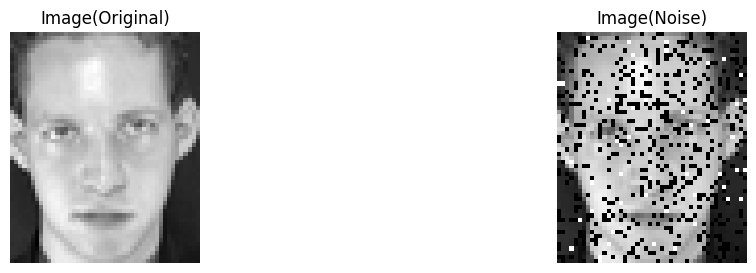

In [96]:
# Load dataset.
print(f"Loading {config['dataset']} dataset ...")
if config["dataset"] == "ORL":
  V_hat, Y_hat, h, w = load_data(root='/content/data/data/ORL', reduce=config["reduce_ORL"], normalization=config["normalization"])
elif config["dataset"] == "YALE":
  V_hat, Y_hat, h, w = load_data(root='/content/data/data/CroppedYaleB', reduce=config["reduce_YALE"], normalization=config["normalization"])
else:
  raise ValueError(f"Unkown dataset in config: {config['dataset']}")

print('V_hat.shape={}, Y_hat.shape={}'.format(V_hat.shape, Y_hat.shape))
print("Image count = ", V_hat.shape[1])
print("Dimensions after reduction:")
print("\theight = ", h)
print("\twidth = ", w)
print("Flattened image vector length = ", V_hat.shape[0])
print("Number of unique labels in Y = ", len(set(Y_hat)))

# check if h*w = pixel count after reduction
if (h*w != V_hat.shape[0]):
  raise ValueError(f"h*w =/= pixel count\nhw = {h*w}\nV_hat.shape[0] = {V_hat.shape[0]}")
  exit(1)



# Plot Result
import matplotlib.pyplot as plt
ind = 2
plt.figure(figsize=(10,3))
plt.subplot(131); plt.imshow(V_hat[:, ind].reshape(h, w), cmap="gray"); plt.title("Image(Original)"); plt.axis("off")

# Add Noise - the old way
# V_noise = rng.random(V_hat.shape) * config["noise_scalar"]
# V = V_hat + V_noise

# Add Noise - the Salt and Pepper way
V = add_sp_noise(V_hat, config["noise_p"], config["noise_r"])

# plt.subplot(132); plt.imshow(V_noise[:, ind].reshape(h, w), cmap="gray"); plt.title("Noise"); plt.axis("off")
plt.subplot(133); plt.imshow(V[:, ind].reshape(h, w), cmap="gray"); plt.title("Image(Noise)"); plt.axis("off")
plt.show()


In [117]:
# Defining NMF Funtions

# FSE method
def frobenius_squared_error(V, W, H):
    WH = W @ H
    return np.sum((V - WH) ** 2)

def rre_fse(V_hat, W, H, eps=1e-12): # V_hat is the clean matrix (pre-noise)
  WH = W @ H
  FE = np.linalg.norm( V_hat - WH, ord='fro')
  denom = np.linalg.norm(V_hat, ord='fro')
  RRE = FE / (denom + eps)
  return RRE

def fse_mur(V, W, H, max_iterations, eps=1e-12, verbosity=1):
  if verbosity >= 1:
    print("Starting FSE MUR training...")
  errors = []
  prev = None

  iterations_done = 0

  for it in range(max_iterations):
      numerator_H = W.T @ V
      denominator_H = (W.T @ W @ H)

      H = H * numerator_H / (denominator_H + eps)

      numerator_W = V @ H.T
      denominator_W = (W @ H @ H.T)

      W = W * numerator_W / (denominator_W + eps)

      training_error = frobenius_squared_error(V, W, H)
      errors.append(training_error)
      iterations_done += 1

      if (iterations_done%100) == 0:
        if verbosity >= 1:
          print(f"Completed {iterations_done} iterations out of {max_iterations}")
        if verbosity >= 2:
          print(f"\t Training error = {training_error:.2f}")

      # check for early stopping
      if prev is None:
        prev = training_error
        continue

      if prev is not None:
        rel = abs(training_error - prev) / (abs(prev) + eps)
        if rel < config["tol"]: # if the curve has flattened too much or is going up
          if verbosity >= 1:
            print("Early stopping at iteration: ", it) # stop
          break
        prev = training_error

  if verbosity >= 1:
    print(f"Completed {iterations_done} iterations")

  return W, H, errors

# L2,1 Norm method

def l21_norm(V, W, H): # finds the L_2,1 Norm objective function result
    R = V - W @ H
    return np.linalg.norm(R, axis=0).sum(0) #axis =0 means we go column by column

def compute_u(V, WH, eps=1e-12): # computes u the vector instead of matrix U. Faster calculations
    R = V - WH
    col_norms = np.linalg.norm(R, axis=0) # gets a vector of all the norms of the columns of R
    u = 1.0 / np.maximum(col_norms, eps) # inverts them
    return u

def rre_l21_norm(V_hat, W, H, eps=1e-12):
  R = V_hat - W @ H
  nom = np.linalg.norm(R, axis=0).sum(0)
  denom = np.linalg.norm(V_hat, axis=0).sum(0)
  RRE = nom / (denom + eps)
  return RRE

def l21_norm_mur(V, W, H, max_iterations, eps=1e-12, delta=1e-12, verbosity=1): # does the H update and W update steps for L21 NMF
  if verbosity >= 1:
    print("Staring L2,1 Norm NMF MUR training...")
  errors = []
  prev = None
  iterations_done = 0

  for it in range(max_iterations):
      # precompute some variables to save runtime
      WH = W @ H
      u = compute_u(V, WH, eps=eps) # finds u but as a vector, not full diagonal matrix U
      V_u = V * u

      numerator_H = W.T @ (V_u)
      denominator_H = W.T @ (WH * u) + delta # includes delta to avoid division by zero

      H *= numerator_H / denominator_H # updates H
      H = np.maximum(H, 0) # clips it to keep it non-negative

      WH = W@H # recompute now that we've updated H

      numerator_W = (V_u) @ H.T
      denominator_W = (WH * u) @ H.T + delta

      W *= numerator_W / denominator_W # updates W
      W = np.maximum(W, 0) # clips it to keep it non-negative

      training_error = l21_norm(V, W, H)
      errors.append(training_error) # tracks the objective function value at each update step
      iterations_done += 1

      if (iterations_done%100) == 0:
        if verbosity >= 1:
          print(f"Completed {iterations_done} iterations out of {max_iterations}")
        if verbosity >= 2:
          print(f"\tTraining error = {training_error:.2f}")

      # check for early stopping
      if prev is None:
        prev = training_error
        continue

      if prev is not None:
        rel = abs(training_error - prev) / (abs(prev) + eps)
        if rel < config["tol"]: # if the curve has flattened too much or is going up
          if verbosity >= 1:
            print("Early stopping at iteration: ", it) # stop
          break
        prev = training_error

  if verbosity >= 1:
    print(f"Completed {iterations_done} iterations")
  return W, H, errors



In [118]:
# randomly select 90%
def make_stratified_subset(V, Y, V_hat, frac=0.9, seed=0):
  rng = np.random.default_rng(seed)
  labels = np.unique(Y)
  idx_trimmed = []
  # print(labels)
  for cls in labels:
    cls_idx = np.where(Y == cls)[0]
    amount_to_keep = int(frac * len(cls_idx))
    chosen = rng.choice(cls_idx, size=amount_to_keep, replace=False)
    idx_trimmed.extend(chosen)
  idx_trimmed = np.array(idx_trimmed)
  V_trimmed = V[:, idx_trimmed]
  Y_trimmed = Y[idx_trimmed]
  V_hat_trimmed = V_hat[:, idx_trimmed]
  return V_trimmed, Y_trimmed, V_hat_trimmed

V_trimmed, Y_trimmed, V_hat_trimmed = make_stratified_subset(V, Y_hat, V_hat)


In [99]:
# Initialisation
if config["rank"] == "auto":
  rank = len(set(Y_trimmed))
elif isinstance(config["rank"], int):
  rank = config["rank"]
else:
  raise ValueError(f"Error! config rank must be an integer or auto. It is currently {config['rank']}")

print("rank = ", rank)

# randomly initialise the values of W and H
W_0 = rng.random((V_trimmed.shape[0], rank))
H_0 = rng.random((rank, V_trimmed.shape[1]))

print(f"starting W dimensions: {V_trimmed.shape[0]} x {rank}")
print(f"starting H dimensions: {rank} x {V_trimmed.shape[1]}")

# optional
# print("starting W = \n", W_0)
# print("starting H = \n", H_0)

rank =  40
starting W dimensions: 2576 x 40
starting H dimensions: 40 x 360


In [100]:
# call the NMF algorithm and output the RRE (dependant on which NMF algorithm)
import time
start = time.time()

if config["nmf_type"] == "Frobenius":
  W, H, errors = fse_mur(V_trimmed, W_0, H_0, max_iterations=config["max_iterations"])
  end = time.time()
  RRE = rre_fse(V_hat_trimmed, W, H)
  print(f"FSE RRE = {RRE:.6f}")

elif config["nmf_type"] == "L21":
  W, H, errors = l21_norm_mur(V_trimmed, W_0, H_0, max_iterations=config["max_iterations"])
  end = time.time()
  RRE = rre_l21_norm(V_hat_trimmed, W, H)
  print(f"L2,1 Norm RRE = {RRE:.6f}")
else:
  raise ValueError(f"Unkown NMF type selected in config: {config['nmf_type']}")
  exit(1)

print(f"Training completed in {end - start:.2f} seconds")
# previous way for time
# Early stopping at iteration:  1247
# Completed 1248 iterations
# L2,1 Norm RRE = 0.217566
# Training completed in 262.24 seconds

# after some tweaks
# Early stopping at iteration:  1226
# Completed 1227 iterations
# L2,1 Norm RRE = 0.217306
# Training completed in 90.11 seconds

# FSE Yale = 560 seconds


#FSE ORL - 66.76 secs
#FSE ORL without error calc - 45.12



Starting FSE MUR training...
Completed 100 iterations out of 10000
	 Training error = 51235.19
Completed 200 iterations out of 10000
	 Training error = 49663.42
Completed 300 iterations out of 10000
	 Training error = 49186.96
Completed 400 iterations out of 10000
	 Training error = 48941.39
Completed 500 iterations out of 10000
	 Training error = 48790.65
Completed 600 iterations out of 10000
	 Training error = 48688.91
Completed 700 iterations out of 10000
	 Training error = 48616.72
Completed 800 iterations out of 10000
	 Training error = 48561.77
Early stopping at iteration:  806
Completed 807 iterations
FSE RRE = 0.280295
Training completed in 31.83 seconds


In [101]:
# Optional - Printing the final W, H, WH, and normalised W

print("final H = \n", np.round(H, 2))
print("final W = \n", np.round(W, 2))
print("final WH = \n", np.round((W @ H), 2))
W_norm = W / (W.sum(axis=1, keepdims=True) + eps) # let's us see the relative influence of the weight matrix elements
print("W-Norm = \n", np.round(W_norm, 2))

final H = 
 [[0.   0.   0.   ... 0.   0.03 0.  ]
 [0.   0.   0.   ... 0.   0.   0.02]
 [0.12 0.01 0.02 ... 0.   0.   0.  ]
 ...
 [0.   0.   0.   ... 0.02 0.02 0.07]
 [0.   0.   0.02 ... 0.   0.02 0.06]
 [0.05 0.03 0.   ... 0.   0.01 0.  ]]
final W = 
 [[0.33 1.01 0.   ... 0.03 0.   0.  ]
 [0.22 0.32 0.   ... 0.2  0.06 0.  ]
 [0.   0.7  0.   ... 0.39 0.   0.  ]
 ...
 [1.06 0.   0.   ... 2.17 0.   0.  ]
 [1.36 0.   0.42 ... 2.03 0.   0.06]
 [1.26 0.   0.62 ... 1.76 0.   0.01]]
final WH = 
 [[0.23 0.12 0.03 ... 0.39 0.47 0.49]
 [0.21 0.17 0.24 ... 0.35 0.4  0.36]
 [0.12 0.18 0.05 ... 0.41 0.48 0.5 ]
 ...
 [0.18 0.21 0.09 ... 0.33 0.22 0.28]
 [0.17 0.11 0.03 ... 0.27 0.22 0.29]
 [0.22 0.08 0.05 ... 0.27 0.21 0.29]]
W-Norm = 
 [[0.02 0.07 0.   ... 0.   0.   0.  ]
 [0.02 0.02 0.   ... 0.01 0.   0.  ]
 [0.   0.05 0.   ... 0.03 0.   0.  ]
 ...
 [0.08 0.   0.   ... 0.16 0.   0.  ]
 [0.1  0.   0.03 ... 0.15 0.   0.  ]
 [0.09 0.   0.05 ... 0.13 0.   0.  ]]


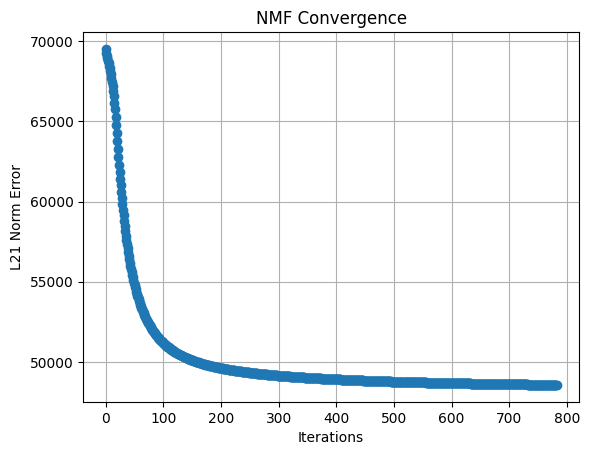

In [125]:
# plot the errors

plt.plot(errors, marker='o')
plt.xlabel("Iterations")
if config["nmf_type"] == "Frobenius":
  plt.ylabel("Frobenius Squared Error")
elif config["nmf_type"] == "L21":
  plt.ylabel("L21 Norm Error")
plt.title("NMF Convergence")
plt.grid(True)
plt.show()

### 2.2 Evaluate Clustering Performance

1. Accuracy.
    
    $$ Acc(Y, Y_{pred}) = \frac{1}{n}\sum\limits_{i=1}^n 1\{Y_{pred}(i) == Y(i)\}$$
        
2. Normalized Mutual Information (NMI).

    $$ NMI(Y, Y_{pred}) = \frac{2 * I(Y, Y_{pred})}{H(Y) + H(Y_{pred})} $$
    
   where $ I(\cdot,\cdot) $ is mutual information and $ H(\cdot) $ is entropy.

In [124]:
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics import normalized_mutual_info_score

def assign_cluster_label(X, Y, verbosity=1):
    if verbosity >= 2:
      print("Num of classes = ", len(set(Y)))
    kmeans = KMeans(n_clusters=len(set(Y))).fit(X)
    Y_pred = np.zeros(Y.shape)
    for i in set(kmeans.labels_):
        ind = kmeans.labels_ == i
        Y_pred[ind] = Counter(Y[ind]).most_common(1)[0][0] # assign label.
    return Y_pred

print('==> Evaluate Acc and NMI ...')

# Assign cluster labels.
# Y_pred = assign_cluster_label(H.T, Y_hat)
Y_pred = assign_cluster_label(H.T, Y_trimmed)

acc = accuracy_score(Y_trimmed, Y_pred)
nmi = normalized_mutual_info_score(Y_trimmed, Y_pred)
print('Acc(NMI) = {:.4f} ({:.4f})'.format(acc, nmi))


==> Evaluate Acc and NMI ...
Acc(NMI) = 0.6139 (0.7815)


h =  56
w =  46


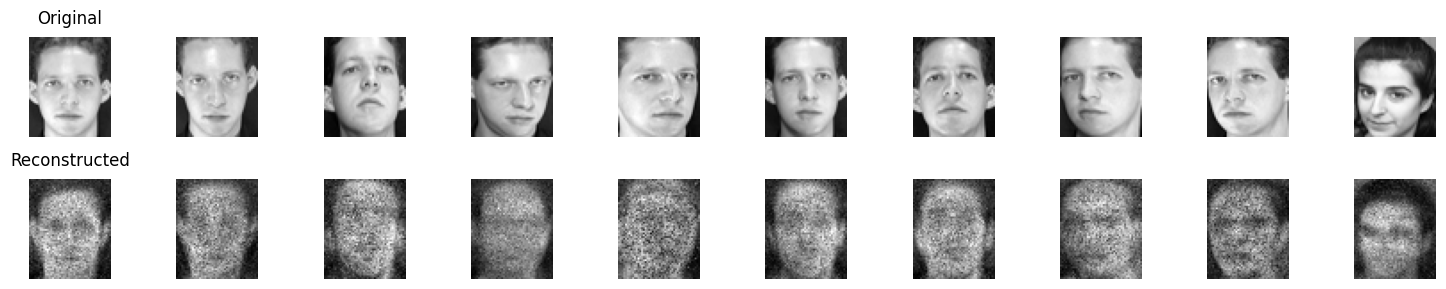

In [123]:
import numpy as np
import matplotlib.pyplot as plt

# Reconstructing the images from the W and H (compared to the originals)
# Needs more work, ignore for now!

def plot_reconstructions(V_hat, W, H, h=None, w=None, n_images=10):
    m, n = V_hat.shape
    V = W @ H

    n_images = min(n_images, n)
    fig, axes = plt.subplots(2, n_images, figsize=(1.5*n_images, 3))

    for i in range(n_images):
        # Original
        axes[0, i].imshow(V_hat[:, i].reshape(h, w), cmap="gray")
        axes[0, i].axis("off")
        if i == 0:
            axes[0, i].set_ylabel("Original", fontsize=12)
            axes[0, i].set_title("Original", fontsize=12, pad=10)

        # Reconstruction
        axes[1, i].imshow(V[:, i].reshape(h, w), cmap="gray")
        axes[1, i].axis("off")
        if i == 0:
            axes[1, i].set_ylabel("Reconstructed", fontsize=12)
            axes[1, i].set_title("Reconstructed", fontsize=12, pad=10)

    plt.tight_layout()
    plt.show()


# hardcoding these for now
# h = 56
# w = 46

print("h = ", h)
print("w = ", w)
plot_reconstructions(V_hat_trimmed, W, H, h, w, n_images=10)


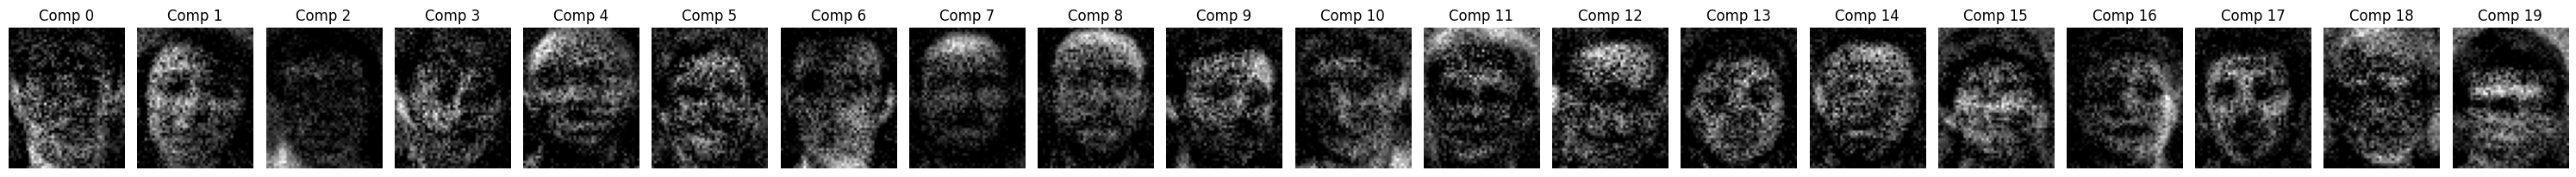

In [122]:
#attempting feature extraction! This needs more work, can ignore for now!

import numpy as np
import matplotlib.pyplot as plt


# Known original (height, width) pairs before reduction
_KNOWN_HW = [(112, 92),  # ORL
             (192, 168)] # Extended YaleB (cropped)

def _infer_hw_from_num_pixels(m):
    for H0, W0 in _KNOWN_HW:
        for r in range(1, max(H0, W0)+1):
            if (H0 % r == 0) and (W0 % r == 0):
                h, w = H0 // r, W0 // r
                if h * w == m:
                    return h, w


def plot_basis_images(W, V_hat=None, h=None, w=None, n_components=20):
    if h is None or w is None:
        m = (V_hat.shape[0] if V_hat is not None else W.shape[0])
        h, w = _infer_hw_from_num_pixels(int(m))

    k = W.shape[1]
    n = min(n_components, k)

    fig, axes = plt.subplots(1, n, figsize=(1.5*n, 2))
    if n == 1:
        axes = [axes]
    for i in range(n):
        ax = axes[i]
        ax.imshow(W[:, i].reshape(h, w), cmap="gray")
        ax.set_title(f"Comp {i}")
        ax.axis("off")
    plt.tight_layout()
    plt.show()


plot_basis_images(W, V_hat=V_hat, n_components=20)


In [132]:
# running the whole thing!
# CONFIG - adjust these as the settings
import numpy as np
import time
import os
from PIL import Image




def run_config(config, verbosity=1):
  rng = np.random.default_rng(config["seed"])
  eps = config["epsilon"]

  for key, value in config.items():
    print(f"{key}: {value}")
  print()

  # Load dataset.
  if verbosity >= 1:
    print(f"Loading {config['dataset']} dataset ...")
  if config["dataset"] == "ORL":
    V_hat, Y_hat, h, w = load_data(root='/content/data/data/ORL', reduce=config["reduce_ORL"], normalization=config["normalization"])
  elif config["dataset"] == "YALE":
    V_hat, Y_hat, h, w = load_data(root='/content/data/data/CroppedYaleB', reduce=config["reduce_YALE"], normalization=config["normalization"])
  else:
    raise ValueError(f"Unkown dataset in config: {config['dataset']}")

  if verbosity >= 2:
    print('V_hat.shape={}, Y_hat.shape={}'.format(V_hat.shape, Y_hat.shape))
    print("Image count = ", V_hat.shape[1])
    print("Dimensions after reduction:")
    print("\theight = ", h)
    print("\twidth = ", w)
    print("Flattened image vector length = ", V_hat.shape[0])
    print("Number of unique labels in Y = ", len(set(Y_hat)))



  # check if h*w = pixel count after reduction
  if (h*w != V_hat.shape[0]):
    raise ValueError(f"h*w =/= pixel count\nhw = {h*w}\nV_hat.shape[0] = {V_hat.shape[0]}")
    exit(1)

  # Add Noise - the Salt and Pepper way
  V = add_sp_noise(V_hat, config["noise_p"], config["noise_r"])

  max_runs = 5

  rre_scores = []
  acc_scores = []
  nmi_scores = []

  for i in range(max_runs):
    if verbosity >= 1:
      print(f"\nStarting run {i+1} of {max_runs}\n")
    # trim to get 90% subset
    V_trimmed, Y_trimmed, V_hat_trimmed = make_stratified_subset(V, Y_hat, V_hat)

    # Initialisation
    if config["rank"] == "auto":
      rank = len(set(Y_trimmed))
    elif isinstance(config["rank"], int):
      rank = config["rank"]
    else:
      raise ValueError(f"Error! config rank must be an integer or auto. It is currently {config['rank']}")

    # randomly initialise the values of W and H
    W_0 = rng.random((V_trimmed.shape[0], rank))
    H_0 = rng.random((rank, V_trimmed.shape[1]))

    # call the NMF algorithm and output the RRE (dependant on which NMF algorithm)
    start = time.time()

    if config["nmf_type"] == "Frobenius":
      W, H, errors = fse_mur(V_trimmed, W_0, H_0, max_iterations=config["max_iterations"], verbosity=verbosity)
      end = time.time()
      RRE = rre_fse(V_hat_trimmed, W, H)
      if verbosity >= 1:
        print(f"FSE RRE = {RRE:.6f}")

    elif config["nmf_type"] == "L21":
      W, H, errors = l21_norm_mur(V_trimmed, W_0, H_0, max_iterations=config["max_iterations"], verbosity=verbosity)
      end = time.time()
      RRE = rre_l21_norm(V_hat_trimmed, W, H)
      if verbosity >= 1:
        print(f"L2,1 Norm RRE = {RRE:.6f}")
    else:
      raise ValueError(f"Unkown NMF type selected in config: {config['nmf_type']}")
      exit(1)

    if verbosity >= 1:
      print(f"Training completed in {end - start:.2f} seconds")

    rre_scores.append(RRE)

    # Assign cluster labels.
    Y_pred = assign_cluster_label(H.T, Y_trimmed, verbosity=verbosity)

    acc = accuracy_score(Y_trimmed, Y_pred)
    nmi = normalized_mutual_info_score(Y_trimmed, Y_pred)
    if verbosity >= 1:
      print(f"Acc: {acc:.4f} NMI: {nmi:.4f}")

    acc_scores.append(acc)
    nmi_scores.append(nmi)


  # final results, output the mean and stdev for each of the three metrics
  print(f"\nRRE mean: {np.mean(rre_scores):.4f} std: {np.std(rre_scores):.4f}")
  print(f"ACC mean: {np.mean(acc_scores):.4f} std: {np.std(acc_scores):.4f}")
  print(f"NMI mean: {np.mean(nmi_scores):.4f} std: {np.std(nmi_scores):.4f}")


  print("\n------------------------------------------\n")

  return







In [136]:


configs = [
    {
    "dataset": "ORL",             # "ORL" or "YALE"
    "normalization": "per_image",  # "none" or "per_image" or "global"
    "noise_p": 0.2,
    "noise_r": 0.1,
    "nmf_type": "Frobenius",            # "Frobenius" or "L21"
    "rank": "auto",               # shared dimension between W and H. Set as an int or as "auto" to be num of classes in Y
    "max_iterations": 10000,
    "tol": 1e-5,                  # Tolerance, allows for early stopping
    "seed": 0,                    # the seeding for RNG. Allows consistent replication
    "reduce_ORL": 2,              # Reduction factor. ORL pics are smaller so maybe reduce less
    "reduce_YALE": 3,             # YALE pics are larger so can reduce more
    "epsilon": 1e-12
},
    {
    "dataset": "ORL",             # "ORL" or "YALE"
    "normalization": "per_image",  # "none" or "per_image" or "global"
    "noise_p": 0.2,
    "noise_r": 0.1,
    "nmf_type": "L21",            # "Frobenius" or "L21"
    "rank": "auto",               # shared dimension between W and H. Set as an int or as "auto" to be num of classes in Y
    "max_iterations": 10000,
    "tol": 1e-5,                  # Tolerance, allows for early stopping
    "seed": 0,                    # the seeding for RNG. Allows consistent replication
    "reduce_ORL": 2,              # Reduction factor. ORL pics are smaller so maybe reduce less
    "reduce_YALE": 3,             # YALE pics are larger so can reduce more
    "epsilon": 1e-12
},
    {
    "dataset": "ORL",             # "ORL" or "YALE"
    "normalization": "per_image",  # "none" or "per_image" or "global"
    "noise_p": 0.3,
    "noise_r": 0.4,
    "nmf_type": "Frobenius",            # "Frobenius" or "L21"
    "rank": "auto",               # shared dimension between W and H. Set as an int or as "auto" to be num of classes in Y
    "max_iterations": 10000,
    "tol": 1e-5,                  # Tolerance, allows for early stopping
    "seed": 0,                    # the seeding for RNG. Allows consistent replication
    "reduce_ORL": 2,              # Reduction factor. ORL pics are smaller so maybe reduce less
    "reduce_YALE": 3,             # YALE pics are larger so can reduce more
    "epsilon": 1e-12
},
]

for i in range(len(configs)):
    print(f"Starting config {i+1} of {len(configs)}\n")
    run_config(config, verbosity=0)


Starting config 1 of 3

dataset: ORL
normalization: per_image
noise_p: 0.3
noise_r: 0.4
nmf_type: Frobenius
rank: auto
max_iterations: 10000
tol: 1e-05
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

RRE mean: 0.2977 std: 0.0004
ACC mean: 0.5117 std: 0.0185
NMI mean: 0.6833 std: 0.0049

Starting config 2 of 3

dataset: ORL
normalization: per_image
noise_p: 0.3
noise_r: 0.4
nmf_type: Frobenius
rank: auto
max_iterations: 10000
tol: 1e-05
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

RRE mean: 0.2984 std: 0.0005
ACC mean: 0.5372 std: 0.0263
NMI mean: 0.6976 std: 0.0155

Starting config 3 of 3

dataset: ORL
normalization: per_image
noise_p: 0.3
noise_r: 0.4
nmf_type: Frobenius
rank: auto
max_iterations: 10000
tol: 1e-05
seed: 0
reduce_ORL: 2
reduce_YALE: 3
epsilon: 1e-12

RRE mean: 0.2971 std: 0.0003
ACC mean: 0.5256 std: 0.0261
NMI mean: 0.6891 std: 0.0164

